# ARIMA with Day of Week Exogenous Variables
## Predicting stock close prices using ARIMA

In [1]:
from td.client import TDClient
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib as mlb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model

In [2]:
from api_info import client_id, redirect_uri

TDSession = TDClient(
    client_id=client_id,
    redirect_uri=redirect_uri,
    credentials_path='./td_state.json'
)

# Login to the session
TDSession.login()

True

In [3]:
stock_history = TDSession.get_price_history('AMD', extended_hours=False, period=2, period_type='year', frequency=1, frequency_type='daily')

In [4]:
stock_df = pd.DataFrame(stock_history).drop(columns=['empty', 'symbol'])

In [5]:
print(stock_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   candles  506 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB
None


In [6]:
stock_flat_df = pd.concat([stock_df.drop(columns=['candles']), pd.DataFrame(stock_df.candles.values.tolist())], axis=1)
stock_flat_df['datetime_formatted'] = pd.to_datetime(stock_flat_df['datetime'], unit='ms')
stock_flat_df['day_of_week'] = stock_flat_df.datetime_formatted.dt.day_of_week
stock_flat_df = pd.get_dummies(stock_flat_df, columns=['day_of_week'], drop_first=True).dropna()
print(stock_flat_df.info())
print(stock_flat_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open                506 non-null    float64       
 1   high                506 non-null    float64       
 2   low                 506 non-null    float64       
 3   close               506 non-null    float64       
 4   volume              506 non-null    int64         
 5   datetime            506 non-null    int64         
 6   datetime_formatted  506 non-null    datetime64[ns]
 7   day_of_week_1       506 non-null    uint8         
 8   day_of_week_2       506 non-null    uint8         
 9   day_of_week_3       506 non-null    uint8         
 10  day_of_week_4       506 non-null    uint8         
dtypes: datetime64[ns](1), float64(4), int64(2), uint8(4)
memory usage: 33.6 KB
None
    open   high    low  close    volume       datetime  datetime_formatted  \
0  3

In [7]:
def plot_price_history(price_df):
    fig = go.Figure(data=[go.Candlestick(x=price_df['datetime_formatted'],
                    open=price_df['open'],
                    high=price_df['high'],
                    low=price_df['low'],
                    close=price_df['close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [8]:
plot_price_history(stock_flat_df)

In [9]:
def autocorr_analysis(series, lags):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    sm.graphics.tsa.plot_acf(series, ax=ax1, lags=lags)
    sm.graphics.tsa.plot_pacf(series, ax=ax2, lags=lags)

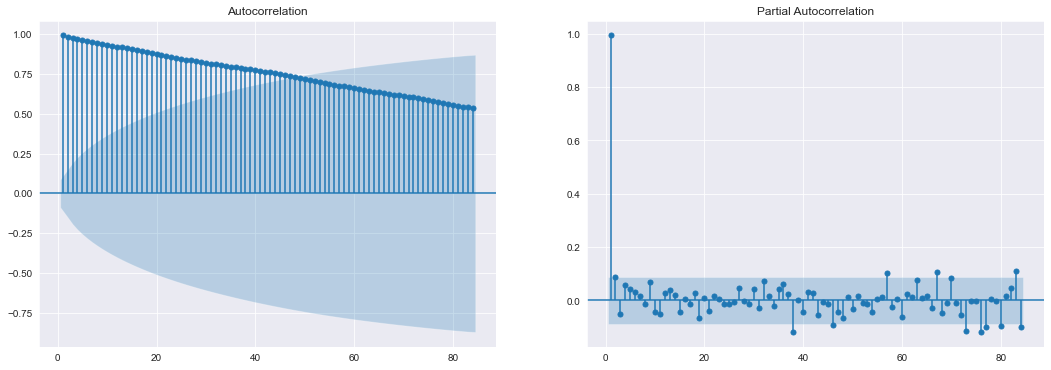

In [10]:
autocorr_analysis(stock_flat_df['close'], range(1,85))

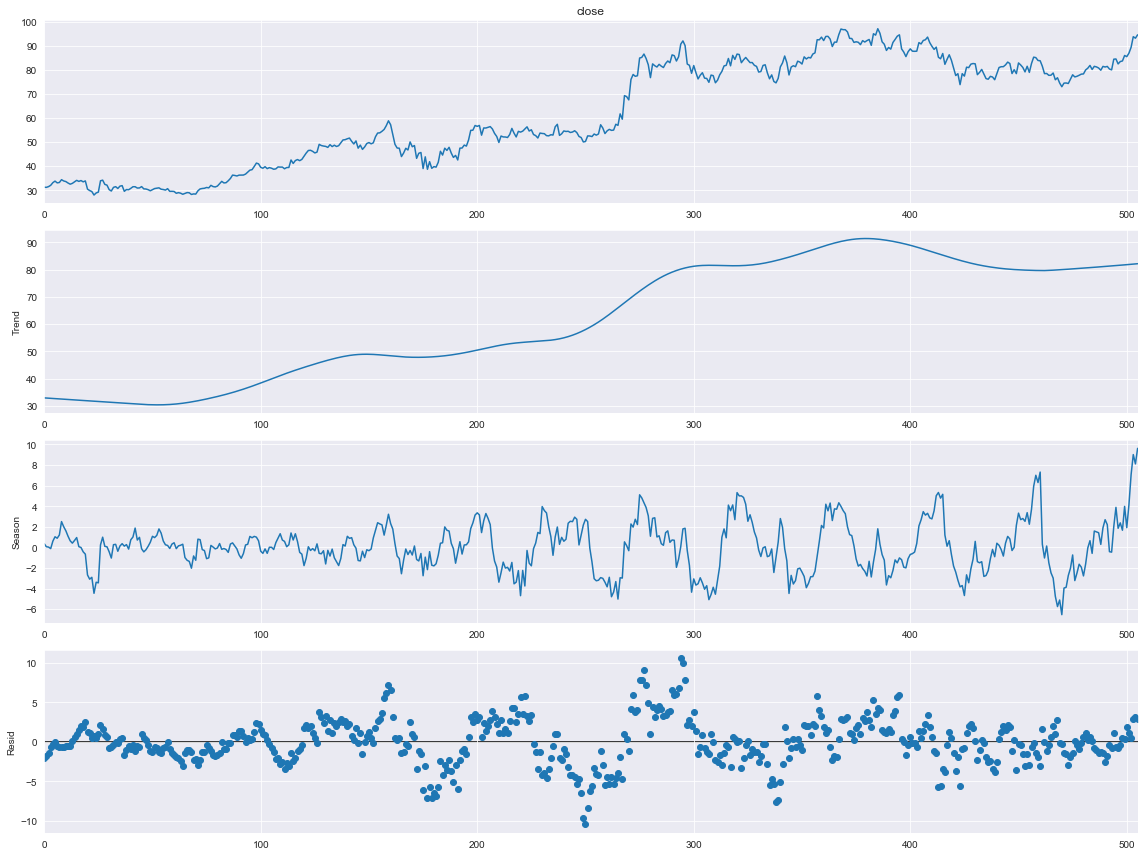

In [11]:
stl = STL(stock_flat_df['close'], period=45)
res = stl.fit()
plt.rc('figure',figsize=(16,12))
fig = res.plot()
plt.show()

In [12]:
stock_flat_df['log_returns'] = np.log1p(stock_flat_df['close']).diff(periods=1)
stock_flat_df.dropna(inplace=True)

In [13]:
train_size = 377
arima_series = stock_flat_df.dropna()
x_features = ['day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
train, test = train_test_split(arima_series, train_size=train_size)
train_y, test_y = train['close'], test['close']
train_x, test_x = train[x_features], test[x_features]

print(train_x.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 1 to 377
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   day_of_week_1  377 non-null    uint8
 1   day_of_week_2  377 non-null    uint8
 2   day_of_week_3  377 non-null    uint8
 3   day_of_week_4  377 non-null    uint8
dtypes: uint8(4)
memory usage: 4.4 KB
None


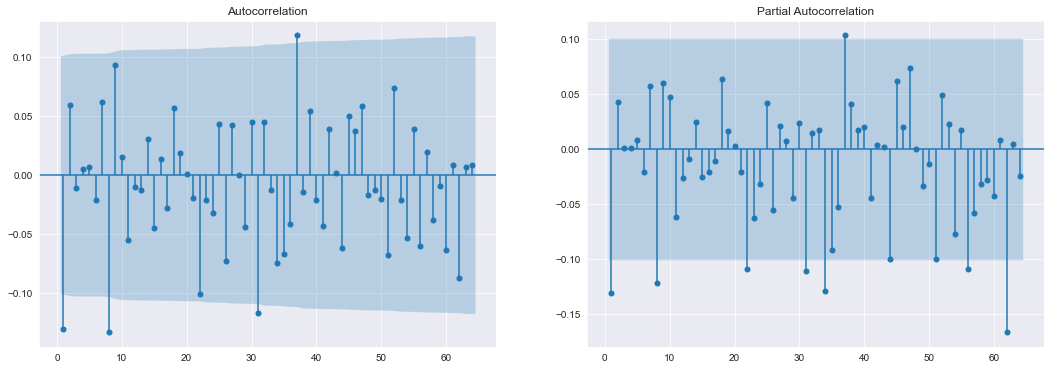

In [14]:
autocorr_analysis(train_y.diff(1).dropna(), lags=range(1,65))

In [15]:
model = pm.auto_arima(train_y, maxiter=200, x=train_x)
print(model.order)

(1, 1, 0)


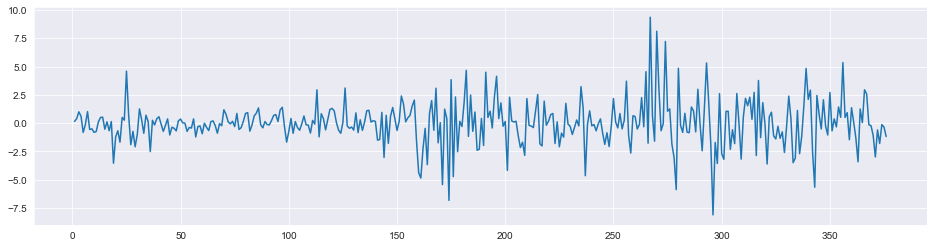

0.00010451706000307362


In [16]:
resid = model.resid()[1:]
# m_resid = manual_model.resid()[1:]
plt.figure(figsize=(16,4))
x = list(range(arima_series.shape[0]))
plt.plot(x[1:train_size], resid)
plt.show()
print(resid.mean())

In [17]:
def resid_analysis(residuals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    fig.suptitle('Residual Analysis', fontsize=18)
    ax1.hist(residuals)

    mlb.rc("figure", figsize=(4,4))
    sm.graphics.tsa.plot_acf(residuals, lags=range(1,30), ax=ax2)
    plt.show()

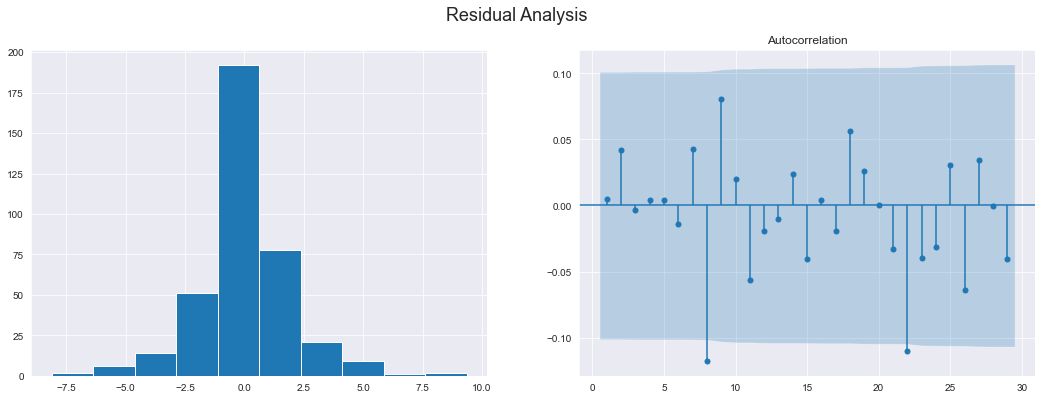

In [18]:
resid_analysis(resid)

In [19]:
def generate_forecasts(test_data, x=None, forecast_period=1, alpha=.05):
    forecasts = []
    conf_ints = np.zeros(shape=(test_data.shape[0]+forecast_period, 2))

    for i in range(0, test_data.shape[0], forecast_period):
        if x is None:
            forecast, conf_int = model.predict(forecast_period, return_conf_int=True, alpha=alpha)
        else:
            forecast, conf_int = model.predict(forecast_period, x=x[i:i+forecast_period], 
                return_conf_int=True, alpha=alpha)
                
        forecasts.extend(forecast)
        conf_ints[i:i+forecast_period, :] = conf_int
        model.update(test_data[i:i+forecast_period])

    return forecasts, conf_ints

In [20]:
forecasts, conf_ints = generate_forecasts(test_y, x=None, forecast_period=5)

In [21]:
forecasts = forecasts[:min(test.shape[0], len(forecasts))]
conf_ints = conf_ints[:len(forecasts)]
print(f"Mean squared error: {mean_squared_error(test_y, forecasts)}")
print(f"Mean absolute error: {mean_absolute_error(test_y, forecasts)}")

Mean squared error: 7.997584757820456
Mean absolute error: 2.2557524981744823


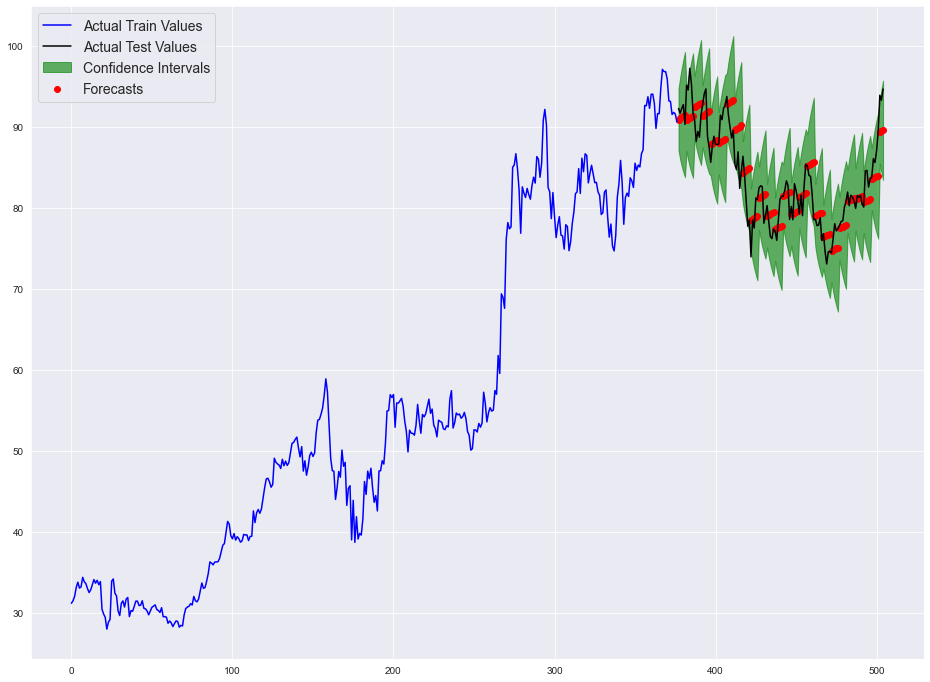

In [22]:
plt.figure(figsize=(16,12))
plt.plot(x[:train_size], train_y, c='blue', label='Actual Train Values')
plt.fill_between(x[train_size:], conf_ints[:, 0], conf_ints[:, 1], alpha=.6, edgecolor='g', facecolor='g', label='Confidence Intervals')
plt.scatter(x[train_size:], forecasts, c='red', label='Forecasts')
plt.plot(x[train_size:], test_y, c='black', alpha=1, label='Actual Test Values')
plt.legend(loc='upper left', fontsize=14)
plt.show()